In [33]:
from tqdm import tqdm
import numpy as np
import pandas as pd

import rasterio as rio

from rasterio.plot import show
from rasterio.merge import merge
from rasterio.mask import mask

from osgeo import gdal
import glob
import geopandas as gpd

tqdm.pandas()

In [34]:
CONTOURS_PATH = '../data/departments_boundaries/departements-20170102-simplified/departements-20170102.shp'

List attributes differenciating files

In [35]:
dates = range(2017, 2022)
sattelites = ['T30TWN', 'T30TWP', 'T30TXN', 'T30TXP', 'T30TYN', 'T30TYP', 'T31TCH', 'T31TCJ']
seasons = range(1,3)
attributes = ['AMPL', 'MAXV', 'MINV', 'QFLAG','LSLOPE', 'RSLOPE']

Reproject riles to EPSG:3035

In [ ]:
for filename in tqdm(glob.iglob(f'*.tif')):
    
    input_raster = gdal.Open(filename)
    output_raster = rf"reproj/{filename}"
    warp = gdal.Warp(srcDSOrSrcDSTab=input_raster,
          destNameOrDestDS=output_raster,
          format="GTiff",
          dstSRS="EPSG:3035")
    warp = None # Closes the files

Merge rasters from different sattelites into one raster

In [8]:
for a in tqdm(attributes):
    for d in tqdm(dates):
        for s in tqdm(seasons):
            rasters = []
            for sat in tqdm(sattelites):
                r = rio.open(f'reproj/VPP_{d}_S2_{sat}-010m_V101_s{s}_{a}.tif')
                rasters.append(r)
            merged, output = merge(rasters)
            output_meta = r.meta.copy()
            output_meta.update(
                {"driver": "GTiff",
                    "height": merged.shape[1],
                    "width": merged.shape[2],
                    "transform": output,
                })
            with rio.open(f'merged/merged_{d}_season{s}_{a}.tif', 'w', **output_meta) as m:
                m.write(merged)

  0%|                                                                                                                           | 0/5 [00:00<?, ?it/s]

  0%|                                                                                                                           | 0/2 [00:00<?, ?it/s]


  0%|                                                                                                                           | 0/8 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 67.80it/s]


 50%|█████████████████████████████████████████████████████████▌                                                         | 1/2 [00:21<00:21, 21.22s/it]


  0%|                                                                                                                           | 0/8 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.97it/s]


 50%|█████████████████████████████████████████████████████████▌                                                         | 1/2 [00:26<00:26, 26.82s/it]


  0%|                                                                                                                           | 0/8 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.48it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:53<00:00, 26.78s/it]

 60%|█████████████████████████████████████████████████████████████████████                                              | 3/5 [02:40<01:47, 53.69s/it]

  0%|                                                                               

  0%|                                                                                                                           | 0/8 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.65it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:51<00:00, 25.71s/it]

 20%|███████████████████████                                                                                            | 1/5 [00:51<03:25, 51.42s/it]

  0%|                                                                                                                           | 0/2 [00:00<?, ?it/s]


  0%|                                                                                                                           | 0/8 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████

Downscale file to 100x100 resolution

In [ ]:
for filename in tqdm(glob.iglob(f'merged/*.tif')):
    
    input_raster = gdal.Open(filename)
    output_raster = f"downscaled/{filename[7:]}"
    warp = gdal.Warp(srcDSOrSrcDSTab=input_raster,
          destNameOrDestDS=output_raster,
          format="GTiff",
          xRes=100, yRes=100)
    warp = None # Closes the files

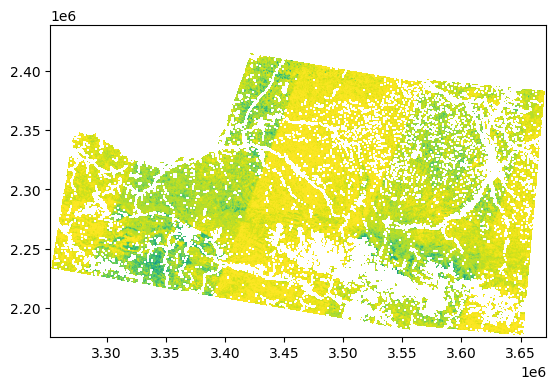

<AxesSubplot:>

In [39]:
merged = rio.open(f'downscaled/merged_2020_season1_QFLAG.tif')
show(merged)

/home/omar/miniconda3/envs/wild/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

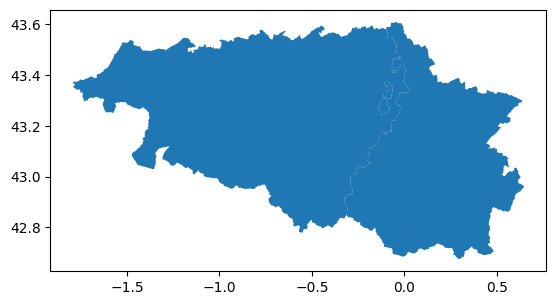

In [40]:
contours = gpd.read_file(CONTOURS_PATH)
pyrenees = contours[(contours.code_insee == '64') | (contours.code_insee == '65')]
pyrenees.plot()

In [41]:
pyrenees_proj = pyrenees.to_crs(epsg='3035')

In [42]:
def crop_raster(r):
    '''
    Crop raster between bounds of departments of interest
    '''
    r_mask, r_transform_mask = mask(
        r, 
        pyrenees_proj.geometry, 
        crop=True, 
        nodata=r.meta['nodata']
    )
    show(r_mask)
    print(r_mask.shape)
    res = r_mask.reshape((1,-1)).T
    return res

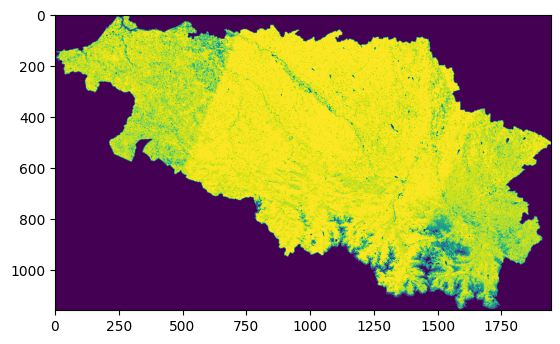

(1, 1157, 1944)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint8)

In [43]:
crop_raster(merged)

Cropped rasters were saved into merged_dimensioned

Create dataframe form data obtained and save it for evey year

In [44]:
for d in tqdm(dates):
    dfs = []
    for a in tqdm(attributes):
        for s in tqdm(seasons):
            r = rio.open(f'merged_dimensioned/merged_{d}_season{s}_{a}.tif')
            res = r.read().reshape((1,-1)).T
            dfs.append(pd.DataFrame(res, columns=[f'{a}_season{s}_{d}']))
    df = pd.concat(dfs, axis=1)
    df.to_pickle(f'generated/vegetation_phenology_{d}.pkl')

  0%|                                                                                                                | 0/6 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 48.42it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.81it/s]

 33%|██████████████████████████████████▋                                                                     | 2/6 [00:00<00:00, 13.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 41.12it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 54.55it/s]

 67%|█████████████████████████████████████████████████████████████████████▎                                  | 4/6 [00:00<00:00, 16.30it/s]

100%|██████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 54.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.09s/it]
